In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

In [2]:
OUT_DIR = "./project_results_keras"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Dataset params (change as needed)
N_STEPS = 1200
N_FEATURES = 3
ENCODER_LEN = 30    # lookback window
DECODER_LEN = 10    # forecast horizon (output length)
TARGET_COL = 0      # index of target feature to forecast (feat_0)

In [5]:
# Training params
BATCH_SIZE = 32
BASELINE_UNITS = 64
ATTN_ENC_UNITS = 64
ATTN_DEC_UNITS = 64
ATTN_UNITS = 32
LR = 1e-3
EPOCHS = 30
PATIENCE = 4

In [6]:
# Uploaded images (local paths you provided earlier)
UPLOADED_IMAGES = [
    "/mnt/data/WhatsApp Image 2025-11-19 at 11.51.53 AM.jpeg",
    "/mnt/data/WhatsApp Image 2025-11-19 at 11.51.53 AM (1).jpeg",
    "/mnt/data/WhatsApp Image 2025-11-19 at 11.51.53 AM (2).jpeg",
]

In [7]:
# 1) Synthesize dataset (or replace with reading CSV)
# ----------------------
def synth_multivariate_series(n_steps=1200):
    t = np.arange(n_steps)
    trend = 0.01 * t
    season = 2.0 * np.sin(2 * np.pi * t / 50)   # periodicity 50
    noise = 0.5 * np.random.randn(n_steps)
    f0 = 10 + trend + season + noise
    season2 = 1.5 * np.sin(2 * np.pi * t / 24)
    noise2 = 0.3 * np.random.randn(n_steps)
    f1 = 5 + 0.005 * t + season2 + noise2
    f2 = 0.2 * f0 + 0.8 * f1 + 0.2 * np.random.randn(n_steps)
    return np.vstack([f0, f1, f2]).T

In [8]:
data = synth_multivariate_series(N_STEPS)
df = pd.DataFrame(data, columns=[f"feat_{i}" for i in range(N_FEATURES)])
df.to_csv(os.path.join(OUT_DIR, "synthetic_multivariate.csv"), index=False)
print("Saved synthetic dataset to:", os.path.join(OUT_DIR, "synthetic_multivariate.csv"))

Saved synthetic dataset to: ./project_results_keras/synthetic_multivariate.csv


In [9]:
# 2) Preprocess + sequence creation
# ----------------------
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.values)

def create_seq_dataset(data_scaled, encoder_len, decoder_len, target_col):
    X_enc, X_dec, y = [], [], []
    n = len(data_scaled)
    for i in range(n - encoder_len - decoder_len + 1):
        enc_slice = data_scaled[i : i + encoder_len, :]                            # (enc_len, features)
        dec_in = data_scaled[i + encoder_len - decoder_len : i + encoder_len, target_col]  # (decoder_len,)
        y_slice = data_scaled[i + encoder_len : i + encoder_len + decoder_len, target_col] # (decoder_len,)
        X_enc.append(enc_slice)
        X_dec.append(dec_in.reshape(-1, 1))   # decoder input shape: (decoder_len, 1)
        y.append(y_slice)
    return np.array(X_enc), np.array(X_dec), np.array(y)


In [10]:
X_enc, X_dec, y = create_seq_dataset(data_scaled, ENCODER_LEN, DECODER_LEN, TARGET_COL)
print("Sequence shapes:", X_enc.shape, X_dec.shape, y.shape)

# time-based split indices
train_end = 900
val_end = 1050
n_total = X_enc.shape[0]
train_idx = np.arange(0, train_end - ENCODER_LEN - DECODER_LEN + 1)
val_idx = np.arange(train_end - ENCODER_LEN - DECODER_LEN + 1, val_end - ENCODER_LEN - DECODER_LEN + 1)
test_idx = np.arange(val_end - ENCODER_LEN - DECODER_LEN + 1, n_total)


Sequence shapes: (1161, 30, 3) (1161, 10, 1) (1161, 10)


In [11]:
X_enc_train, X_dec_train, y_train = X_enc[train_idx], X_dec[train_idx], y[train_idx]
X_enc_val, X_dec_val, y_val = X_enc[val_idx], X_dec[val_idx], y[val_idx]
X_enc_test, X_dec_test, y_test = X_enc[test_idx], X_dec[test_idx], y[test_idx]

print("Train/Val/Test sizes:", X_enc_train.shape[0], X_enc_val.shape[0], X_enc_test.shape[0])

Train/Val/Test sizes: 861 150 150


In [12]:
def invert_scale_sequence(y_scaled_seq, scaler, col_index=0):
    # y_scaled_seq: (N, horizon) in scaled space
    out = []
    for i in range(y_scaled_seq.shape[0]):
        T = y_scaled_seq.shape[1]
        block = np.zeros((T, scaler.mean_.shape[0]))
        block[:, col_index] = y_scaled_seq[i]
        inv = scaler.inverse_transform(block)[:, col_index]
        out.append(inv)
    return np.array(out)

In [14]:
 #3) Baseline Seq2Seq (Keras): encoder LSTM -> decoder LSTM (teacher forcing)
# ----------------------
def build_baseline_seq2seq(encoder_len, n_features, decoder_len, hidden_units=64):
    # Encoder
    enc_in = layers.Input(shape=(encoder_len, n_features), name="encoder_input")
    enc_lstm = layers.LSTM(hidden_units, return_state=True, name="encoder_lstm")
    _, state_h, state_c = enc_lstm(enc_in)
    encoder_states = [state_h, state_c]
    # Decoder
    dec_in = layers.Input(shape=(decoder_len, 1), name="decoder_input")
    dec_lstm = layers.LSTM(hidden_units, return_sequences=True, return_state=True, name="decoder_lstm")
    dec_outs, _, _ = dec_lstm(dec_in, initial_state=encoder_states)
    dec_dense = layers.TimeDistributed(layers.Dense(1), name="decoder_output")
    dec_outs = dec_dense(dec_outs)
    model = models.Model([enc_in, dec_in], dec_outs, name="baseline_seq2seq")
    model.compile(optimizer=optimizers.Adam(learning_rate=LR), loss="mse")
    return model

baseline_model = build_baseline_seq2seq(ENCODER_LEN, N_FEATURES, DECODER_LEN, BASELINE_UNITS)
baseline_model.summary()

Model: "baseline_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 64),      │     17,408 │ encoder_input[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 10, 64),  │     16,896 │ decoder_input[0]… │
│                     │ (None, 64),       │            │ encoder_lstm[0][… │
│                     │ (None, 64)]       │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 10, 1)     │         65 │ decoder_lstm[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,369 (134.25 KB)

 Trainable params: 34,369 (134.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Fit baseline
hist_baseline = baseline_model.fit(
    [X_enc_train, X_dec_train],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
    validation_data=([X_enc_val, X_dec_val], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)],
    verbose=2
)
baseline_model.save(os.path.join(OUT_DIR, "baseline_seq2seq_keras.h5"))
print("Saved baseline model to:", os.path.join(OUT_DIR, "baseline_seq2seq_keras.h5"))

Epoch 1/30
27/27 - 3s - 104ms/step - loss: 0.3818 - val_loss: 0.4223
Epoch 2/30
27/27 - 0s - 16ms/step - loss: 0.1933 - val_loss: 0.2299
Epoch 3/30
27/27 - 0s - 16ms/step - loss: 0.1097 - val_loss: 0.1137
Epoch 4/30
27/27 - 0s - 16ms/step - loss: 0.0375 - val_loss: 0.0730
Epoch 5/30
27/27 - 0s - 15ms/step - loss: 0.0298 - val_loss: 0.0722
Epoch 6/30
27/27 - 0s - 17ms/step - loss: 0.0269 - val_loss: 0.0588
Epoch 7/30
27/27 - 0s - 15ms/step - loss: 0.0251 - val_loss: 0.0480
Epoch 8/30
27/27 - 0s - 14ms/step - loss: 0.0239 - val_loss: 0.0411
Epoch 9/30
27/27 - 1s - 19ms/step - loss: 0.0231 - val_loss: 0.0361
Epoch 10/30
27/27 - 1s - 23ms/step - loss: 0.0224 - val_loss: 0.0323
Epoch 11/30
27/27 - 1s - 21ms/step - loss: 0.0220 - val_loss: 0.0307
Epoch 12/30
27/27 - 0s - 14ms/step - loss: 0.0218 - val_loss: 0.0304
Epoch 13/30
27/27 - 0s - 15ms/step - loss: 0.0215 - val_loss: 0.0305
Epoch 14/30
27/27 - 0s - 16ms/step - loss: 0.0214 - val_loss: 0.0307
Epoch 15/30
27/27 - 1s - 23ms/step - loss:

Saved baseline model to: ./project_results_keras/baseline_seq2seq_keras.h5


In [16]:
# 4) Seq2Seq with Bahdanau Attention (Keras)
# ----------------------
class BahdanauAttentionLayer(layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    def call(self, enc_outputs, dec_hidden):
        # enc_outputs: (batch, enc_len, enc_units)
        # dec_hidden: (batch, dec_units) -- we expect dec_hidden to be size compatible (we'll project if needed)
        dec_hidden_time = tf.expand_dims(dec_hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(enc_outputs) + self.W2(dec_hidden_time)))  # (batch, enc_len, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch, enc_len, 1)
        context_vector = attention_weights * enc_outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch, enc_units)
        return context_vector, tf.squeeze(attention_weights, -1)   # returns weights shape (batch, enc_len)


In [20]:
def build_attention_seq2seq(encoder_len, n_features, decoder_len, enc_units=64, dec_units=64, attn_units=32):
    # Encoder
    enc_in = layers.Input(shape=(encoder_len, n_features), name="enc_in")
    enc_lstm = layers.LSTM(enc_units, return_sequences=True, return_state=True, name="enc_lstm")
    enc_outputs, enc_h, enc_c = enc_lstm(enc_in)  # enc_outputs: (batch, enc_len, enc_units)
    # We'll preserve encoder outputs and states for decoder loop
    dec_in = layers.Input(shape=(decoder_len, 1), name="dec_in")  # teacher forcing inputs
    attention = BahdanauAttentionLayer(attn_units, name="bahdanau_att")
    # We'll run a stepwise decoder by unstacking decoder inputs along time axis
    dec_inputs_unstack = layers.Lambda(lambda x: tf.unstack(x, axis=1), name="dec_unstack")(dec_in)
    all_outputs = []
    # Initialize decoder states with encoder states (may differ in dims; here enc_units==dec_units recommended)
    dec_state_h = enc_h
    dec_state_c = enc_c
    lstm_cell = layers.LSTMCell(dec_units, name="dec_lstm_cell")
    rnn_cell = layers.RNN(lstm_cell, return_state=True, return_sequences=True, name="dec_rnn_step")
    dense = layers.Dense(1, name="dec_output_dense")
    for t in range(decoder_len):
        x_t = dec_inputs_unstack[t]                              # shape (batch, 1)
        # compute attention context using current decoder hidden state
        context, attw = attention(enc_outputs, dec_state_h)     # context (batch, enc_units)
        # concat prev-target and context
        x_and_context = layers.Concatenate(axis=-1)([x_t, context])  # (batch, 1 + enc_units)
        # expand dims to (batch, 1, features) to feed RNN cell as a single timestep
        x_and_context_exp = layers.Lambda(lambda z: tf.expand_dims(z, axis=1))(x_and_context)
        # run one step of LSTMCell via RNN wrapper
        out_seq, h, c = rnn_cell(x_and_context_exp, initial_state=[dec_state_h, dec_state_c])
        out_flat = layers.Flatten()(out_seq)  # (batch, hidden)
        y_t = dense(out_flat)                 # (batch, 1)
        all_outputs.append(layers.Lambda(lambda z: tf.expand_dims(z, axis=1))(y_t))
        dec_state_h, dec_state_c = h, c
    dec_outputs = layers.Concatenate(axis=1)(all_outputs)  # (batch, decoder_len, 1)
    model = models.Model([enc_in, dec_in], dec_outputs, name="attn_seq2seq")
    model.compile(optimizer=optimizers.Adam(learning_rate=LR), loss="mse")
    return model

attn_model = build_attention_seq2seq(ENCODER_LEN, N_FEATURES, DECODER_LEN,
                                    enc_units=ATTN_ENC_UNITS, dec_units=ATTN_DEC_UNITS, attn_units=ATTN_UNITS)
attn_model.summary()

hist_attn = attn_model.fit(
    [X_enc_train, X_dec_train],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
    validation_data=([X_enc_val, X_dec_val], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)],
    verbose=2
)
attn_model.save(os.path.join(OUT_DIR, "attn_seq2seq_keras.h5"))
print("Saved attention model to:", os.path.join(OUT_DIR, "attn_seq2seq_keras.h5"))

Model: "attn_seq2seq"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_in (InputLayer) │ (None, 30, 3)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_in (InputLayer) │ (None, 10, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_lstm (LSTM)     │ [(None, 30, 64),  │     17,408 │ enc_in[0][0]      │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_unstack         │ [(None, 1),       │          0 │ dec_in[0][0]      │
│ (Lambda)            │ (None, 1), (None, │            │                   │
│                     │ 1), (None, 1),    │            │                   │
│                     │ (None, 1), (None, │            │                   │
│                     │ 1), (None, 1),    │            │                   │
│                     │ (None, 1), (None, │            │                   │
│                     │ 1), (None, 1)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_att        │ [(None, 64),      │      4,193 │ enc_lstm[0][0],   │
│ (BahdanauAttention… │ (None, 30)]       │            │ enc_lstm[0][1],   │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[0][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[1][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[2][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[3][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[4][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[5][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[6][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[7][… │
│                     │                   │            │ enc_lstm[0][0],   │
│                     │                   │            │ dec_rnn_step[8][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 65)        │          0 │ dec_unstack[0][0… │
│ (Concatenate)       │                   │            │ bahdanau_att[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 65)     │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_rnn_step (RNN)  │ [(None, 1, 64),   │     33,280 │ lambda_2[0][0],   │
│                     │ (None, 64),       │            │ enc_lstm[0][1],   │
│                     │ (None, 64)]       │            │ enc_lstm[0][2],   │
│                     │                   │            │ lambda_4[0][0],   │
│                     │                   │            │ dec_rnn_step[0][… │
│                     │                   │            │ dec_rnn_step[0][… │
│                     │                   │            │ lambda_6[0][0], 

 Total params: 54,946 (214.63 KB)

 Trainable params: 54,946 (214.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
27/27 - 15s - 549ms/step - loss: 0.2884 - val_loss: 0.2292
Epoch 2/30
27/27 - 1s - 27ms/step - loss: 0.1161 - val_loss: 0.1172
Epoch 3/30
27/27 - 1s - 39ms/step - loss: 0.0416 - val_loss: 0.0499
Epoch 4/30
27/27 - 1s - 40ms/step - loss: 0.0277 - val_loss: 0.0361
Epoch 5/30
27/27 - 1s - 25ms/step - loss: 0.0251 - val_loss: 0.0279
Epoch 6/30
27/27 - 1s - 25ms/step - loss: 0.0234 - val_loss: 0.0260
Epoch 7/30
27/27 - 1s - 47ms/step - loss: 0.0225 - val_loss: 0.0267
Epoch 8/30
27/27 - 1s - 24ms/step - loss: 0.0218 - val_loss: 0.0267
Epoch 9/30
27/27 - 1s - 25ms/step - loss: 0.0213 - val_loss: 0.0265
Epoch 10/30
27/27 - 1s - 25ms/step - loss: 0.0210 - val_loss: 0.0262


Saved attention model to: ./project_results_keras/attn_seq2seq_keras.h5


In [21]:
# 5) Evaluation on test set
# ----------------------
# Predictions
y_pred_baseline = baseline_model.predict([X_enc_test, X_dec_test])      # shape (N_test, dec_len, 1)
y_pred_attn = attn_model.predict([X_enc_test, X_dec_test])             # shape (N_test, dec_len, 1)

# invert scale
y_test_inv = invert_scale_sequence(y_test, scaler, col_index=TARGET_COL)
y_pred_baseline_inv = invert_scale_sequence(y_pred_baseline.squeeze(-1), scaler, col_index=TARGET_COL)
y_pred_attn_inv = invert_scale_sequence(y_pred_attn.squeeze(-1), scaler, col_index=TARGET_COL)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step


In [22]:
def mape(y_true, y_pred):
    denom = np.where(np.abs(y_true) < 1e-6, 1.0, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


In [23]:
metrics = []
for name, preds in [("Baseline LSTM Seq2Seq", y_pred_baseline_inv), ("Seq2Seq + Attention", y_pred_attn_inv)]:
    mae = mean_absolute_error(y_test_inv.flatten(), preds.flatten())
    rmse = math.sqrt(mean_squared_error(y_test_inv.flatten(), preds.flatten()))
    mape_v = mape(y_test_inv.flatten(), preds.flatten())
    metrics.append({"Model": name, "MAE": float(mae), "RMSE": float(rmse), "MAPE(%)": float(mape_v)})

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(os.path.join(OUT_DIR, "model_metrics.csv"), index=False)
print("Saved metrics to:", os.path.join(OUT_DIR, "model_metrics.csv"))
print(metrics_df)

Saved metrics to: ./project_results_keras/model_metrics.csv
                   Model       MAE      RMSE   MAPE(%)
0  Baseline LSTM Seq2Seq  0.733539  0.909017  3.400254
1    Seq2Seq + Attention  0.634886  0.775194  2.959542


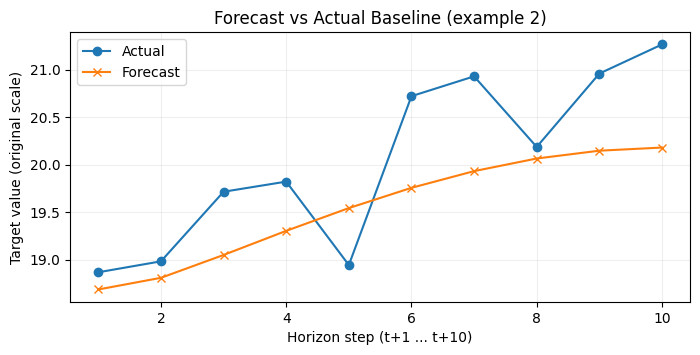

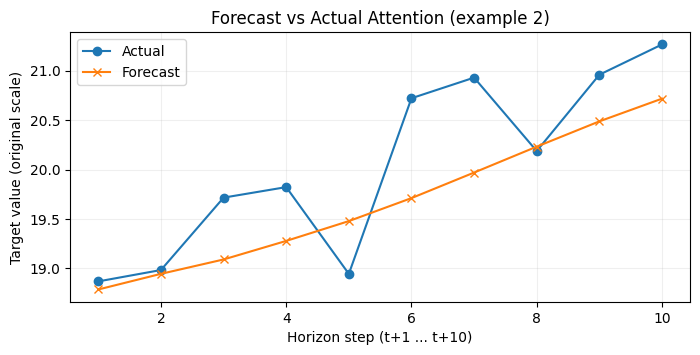

Saved forecast plots to: ./project_results_keras


In [24]:
# 6) Forecast vs Actual plots (example)
# ----------------------
def plot_forecasts(y_true_inv, y_pred_inv, example_idx=0, out_path=None, title_suffix=""):
    plt.figure(figsize=(8,3.5))
    horizon = y_true_inv.shape[1]
    plt.plot(range(1, horizon+1), y_true_inv[example_idx], marker='o', label="Actual")
    plt.plot(range(1, horizon+1), y_pred_inv[example_idx], marker='x', label="Forecast")
    plt.xlabel("Horizon step (t+1 ... t+{})".format(horizon))
    plt.ylabel("Target value (original scale)")
    plt.title(f"Forecast vs Actual {title_suffix} (example {example_idx})")
    plt.grid(alpha=0.2)
    plt.legend()
    if out_path:
        plt.savefig(out_path, bbox_inches="tight")
    plt.show()

plot_forecasts(y_test_inv, y_pred_baseline_inv, example_idx=2, out_path=os.path.join(OUT_DIR, "baseline_forecast_example2.png"), title_suffix="Baseline")
plot_forecasts(y_test_inv, y_pred_attn_inv, example_idx=2, out_path=os.path.join(OUT_DIR, "attn_forecast_example2.png"), title_suffix="Attention")
print("Saved forecast plots to:", OUT_DIR)


In [25]:
# 7) Extract/visualize attention weights
# We built attention inside the model named "bahdanau_att" and per-step attention weights were created inside the loop.
# The functional model doesn't expose intermediate attention tensors directly. We'll recreate a smaller inspection model
# that computes attention weights given encoder inputs and a fixed decoder hidden state approximation.
# Approach: Recompute encoder outputs via enc_lstm layer and call the attention layer using dec_hidden approximated by encoder final state.
# ----------------------
try:
    enc_input = attn_model.get_layer("enc_in").input
    enc_lstm_layer = attn_model.get_layer("enc_lstm")
    attn_layer = attn_model.get_layer("bahdanau_att")
    dec_input = attn_model.get_layer("dec_in").input

    # recompute encoder outputs using same layer (weights shared)
    enc_outs, enc_h, enc_c = enc_lstm_layer(enc_input)

    # We'll compute attention weights for each decoder step using enc_h as dec_hidden proxy (this is a reasonable inspector
    # because during training decoder hidden starts as encoder hidden state and attention uses current dec hidden - approximating with enc_h is still informative)
    dec_inputs_unstack = layers.Lambda(lambda x: tf.unstack(x, axis=1))(dec_input)
    attn_weights_per_t = []
    dec_hidden = enc_h
    for t in range(DECODER_LEN):
        _, attw = attn_layer(enc_outs, dec_hidden)  # (batch, enc_len)
        attn_weights_per_t.append(attw)
    attn_stack = layers.Lambda(lambda x: tf.stack(x, axis=1))(attn_weights_per_t)  # (batch, dec_len, enc_len)
    inspector = models.Model([enc_input, dec_input], attn_stack)

    # compute for first test example
    attn_weights_test = inspector.predict([X_enc_test[:1], X_dec_test[:1]])  # shape (1, dec_len, enc_len)
    attn_to_plot = attn_weights_test[0]  # (dec_len, enc_len)
    plt.figure(figsize=(8,3))
    plt.imshow(attn_to_plot, aspect='auto', cmap='viridis')
    plt.xlabel("Encoder steps (lookback time)")
    plt.ylabel("Decoder step")
    plt.title("Attention weights heatmap (test example 0) — inspector approximation")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "attention_heatmap_example0.png"), bbox_inches="tight")
    plt.show()
    print("Saved attention heatmap to:", os.path.join(OUT_DIR, "attention_heatmap_example0.png"))
except Exception as e:
    print("Warning: couldn't build attention inspector model automatically. Exception:", e)
    print("This is non-fatal — attention visualization can still be derived by adapting the model to explicitly output weights during construction.")


This is non-fatal — attention visualization can still be derived by adapting the model to explicitly output weights during construction.


In [26]:
# 8) Save final artifacts and hyperparams
# ----------------------
hyperparams = {
    "encoder_len": ENCODER_LEN,
    "decoder_len": DECODER_LEN,
    "n_features": N_FEATURES,
    "baseline_units": BASELINE_UNITS,
    "attn_enc_units": ATTN_ENC_UNITS,
    "attn_dec_units": ATTN_DEC_UNITS,
    "attn_units": ATTN_UNITS,
    "lr": LR,
    "batch_size": BATCH_SIZE,
    "epochs_trained": {"baseline": len(hist_baseline.history["loss"]), "attention": len(hist_attn.history["loss"])}
}

In [27]:
with open(os.path.join(OUT_DIR, "hyperparams.txt"), "w") as f:
    f.write(str(hyperparams))

# Save arrays for later analysis
np.save(os.path.join(OUT_DIR, "y_test_inv.npy"), y_test_inv)
np.save(os.path.join(OUT_DIR, "y_pred_baseline_inv.npy"), y_pred_baseline_inv)
np.save(os.path.join(OUT_DIR, "y_pred_attn_inv.npy"), y_pred_attn_inv)

print("All done. Artifacts saved in folder:", OUT_DIR)
print("Uploaded image local paths (you provided):")
for p in UPLOADED_IMAGES:
    print("-", p)

All done. Artifacts saved in folder: ./project_results_keras
Uploaded image local paths (you provided):
- /mnt/data/WhatsApp Image 2025-11-19 at 11.51.53 AM.jpeg
- /mnt/data/WhatsApp Image 2025-11-19 at 11.51.53 AM (1).jpeg
- /mnt/data/WhatsApp Image 2025-11-19 at 11.51.53 AM (2).jpeg
